In [12]:
from img_cap_lib import *
# imports
import torch
import torchvision
import torchtext
from torchtext.vocab import vocab, GloVe, Vectors
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import os
from PIL import Image
import string
from collections import OrderedDict, Counter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import train_test_split
import pickle
import os
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import nltk

# Modellpfad festlegen

In [13]:
model_path = "models/standart_model_with_normalisation.pt"

# Daten herunterladen

In [14]:
data_download("flickr8k")

Data already exi sts at flickr8k


# Modell mit Normalisierung

## Modell laden

In [15]:
# load model
model_stats = torch.load(model_path, map_location=torch.device('cpu'))
model = load_captioning_model(model_stats)

## Preprocessing

In [16]:
# caption preprocessing
embedding_dim = 300
min_frequency = 1

captions = pd.read_csv("flickr8k/captions.txt")
caption_preprocessor = CaptionPreprocessor(embedding=model_stats['embedding'].embedding_matrix, captions_path="flickr8k/captions.txt", vocabulary=model_stats['embedding'].vocabulary ,captions=captions, embedding_dim=embedding_dim, min_frequency=min_frequency)
caption_preprocessor.preprocess()

# image preprocessing
img_preprocessor = ImagePreprocessor(normalize=True, image_folder_path="flickr8k")
img_preprocessor.preprocess_images()

Shape captions: (40460, 2)
Shape captions after filtering: (39749, 3)
Removed Captions:  711 , in Percent:  1.76


/Users/ronnyschneeberger/Documents/FHNW/HS22/del-image-captioning/img_cap_lib.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.captions.caption = self.captions.caption.apply(lambda x: x.strip("."))


transformed_images folder already exists. No preprocessing necessary.


## Datensplit und DataLoader

In [8]:
# create split
training_data, test_data = train_test_split(caption_preprocessor.captions, test_size=0.15, random_state=42)

# create datasets
train_dataset = FlickrDataset(captions=training_data, embedding=model.embedding)
test_dataset = FlickrDataset(captions=test_data, embedding=model.embedding)

# create dataloaders
batch_size = 8
train_loader = FlickrLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = FlickrLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [22]:
with open("scores/tiny_test_scores.pkl", 'rb') as f:
    test_scores = pickle.load(f)

with open("scores/tiny_train_scores.pkl", 'rb') as f:
    train_scores = pickle.load(f)

In [26]:
np.array(test_scores).mean()

0.018172603115732343

In [25]:
np.array(train_scores).mean()

0.018088571603296907

In [9]:
def visualize_model_results(model, df:pd.DataFrame, n_samples=8):
    sample = df.sample(n_samples)

    for i, image_path in enumerate(sample.image.values):
        input = torchvision.io.read_image("flickr8k/transformed_images/" + image_path).float()
        image = Image.open("flickr8k/images/" + image_path)
        plt.imshow(image)
        plt.show()
        print("predicted")
        predicted_caption = model.forward(input.unsqueeze(0))
        predicted_caption = " ".join(predicted_caption)
        predicted_caption = predicted_caption.split('<EOS>')[0]
        predicted_caption = predicted_caption.lstrip('<SOS>')
        print(20*"-")
        print(predicted_caption + "\n")
        print("caption")
        print(20*"-")
        caption = sample["caption"].iloc[i]
        caption = " ".join(eval(caption))
        caption = caption.split('<EOS>')[0]
        caption = caption.lstrip('<SOS>')
        print(caption + "\n")

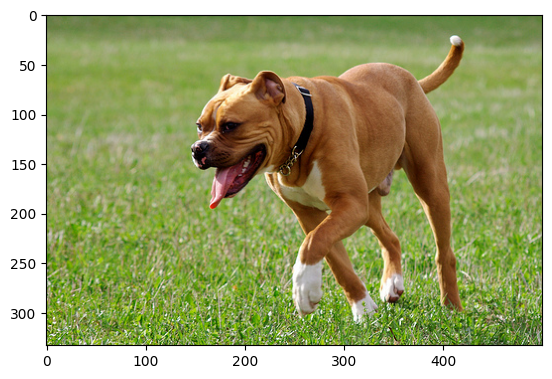

predicted
--------------------
 a brown dog is walking on the grass 

caption
--------------------
 a brown dog in running on grass 



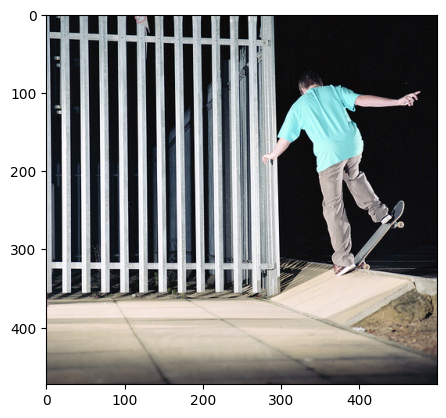

predicted
--------------------
 a young male wearing a blue shirt rides a skateboard in an outdoor park at night 

caption
--------------------
 a man wearing a green shirt is skateboarding on a ramp beside a white fence 



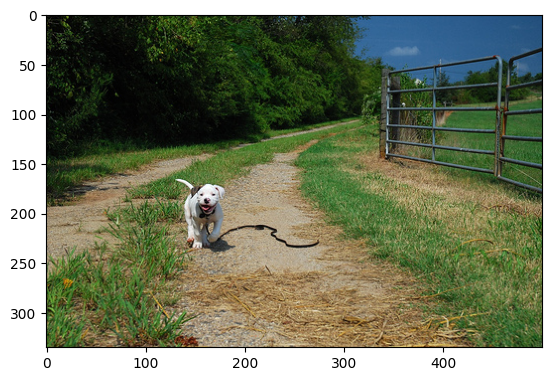

predicted
--------------------
 a white dog is walking down a dirt road 

caption
--------------------
 a white puppy walks down a dirt path trailing his leash on the ground behind him 



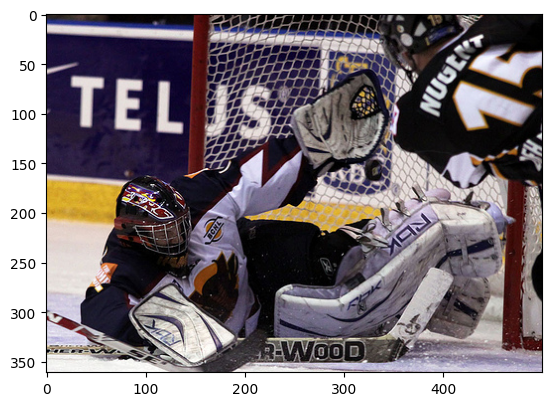

predicted
--------------------
 hockey goaltender diving 

caption
--------------------
 hockey goaltender diving 



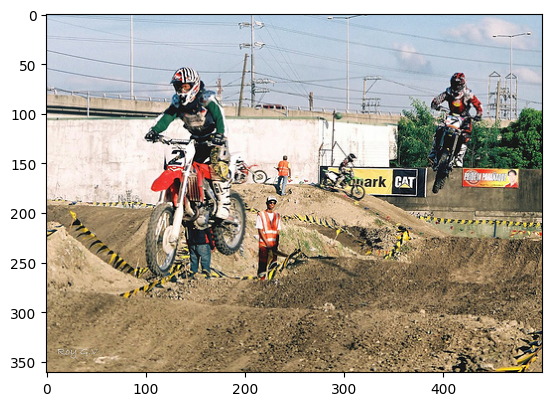

predicted
--------------------
 dirt bikes get airborne at a racetrack 

caption
--------------------
 two people on dirt bikes jumping dirt ramps with several people in the background 



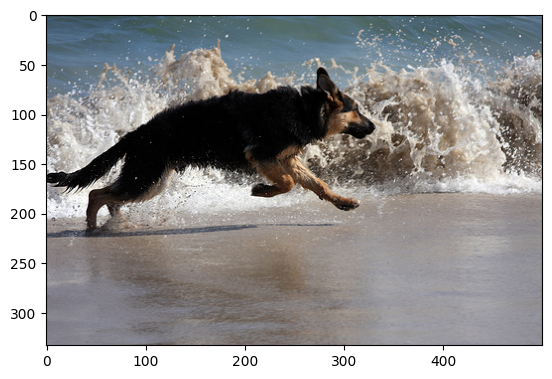

predicted
--------------------
 a dog is running parallel with the ocean waves 

caption
--------------------
 a dog is running parallel with the ocean waves 



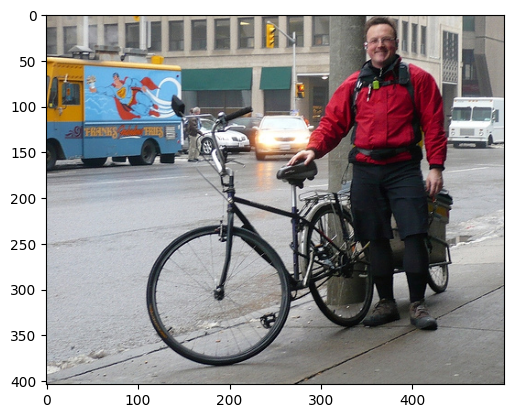

predicted
--------------------
 a man standing beside his bicycle on the street 

caption
--------------------
 a man in a red jacket is standing by a bicycle and trailer in a city street 



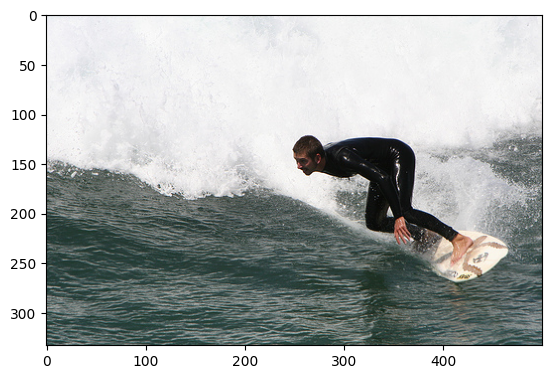

predicted
--------------------
 a surfer in a black wetsuit is riding a foamy wave 

caption
--------------------
 a surfer surfs a huge wave 



In [10]:
visualize_model_results(model, training_data)

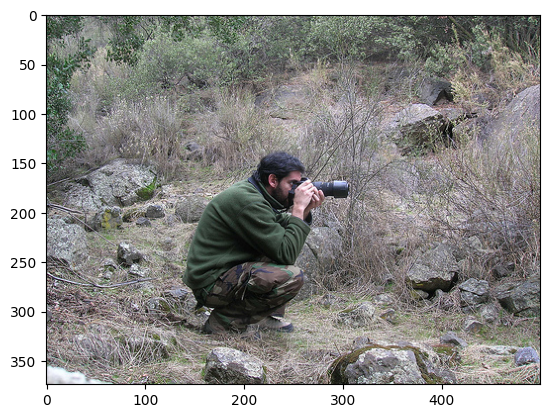

predicted
--------------------
 a man crouching and holding a camera 

caption
--------------------
 a man is squatting in brush to take a photograph 



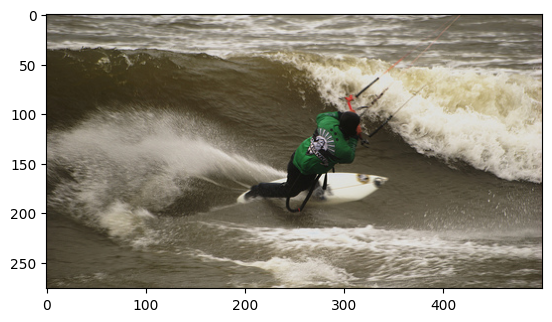

predicted
--------------------
 a lone parasurfer surfing a huge wave in the ocean 

caption
--------------------
 a person in green surfing a wave 



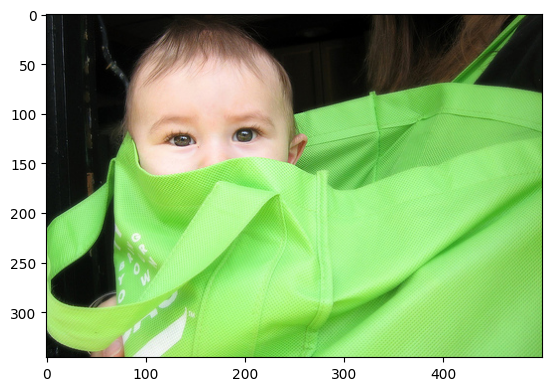

predicted
--------------------
 a child is sitting in a green tote bag with only its eyes and hair poking out 

caption
--------------------
 a child is mostly hidden in a green shopping bag 



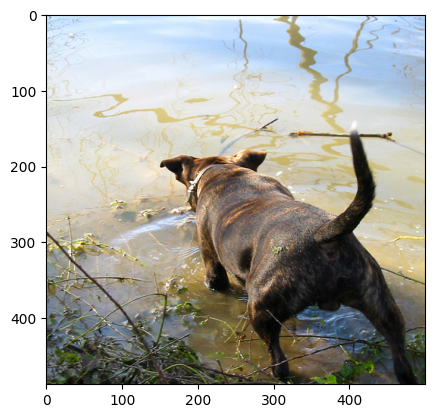

predicted
--------------------
 a brown dog drinks from a body of water 

caption
--------------------
 a brown dog is starting to walk into water 



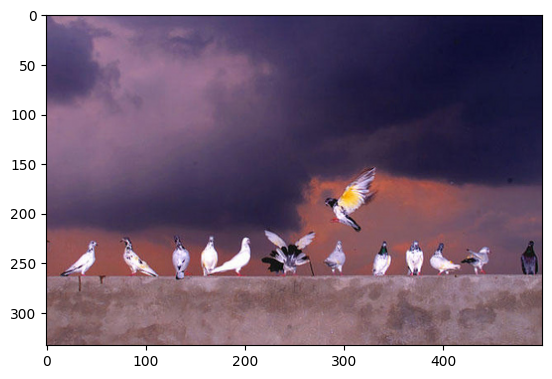

predicted
--------------------
 many birds are sitting on a concrete wall 

caption
--------------------
 a row of birds is sitting in front of a grey cloud 



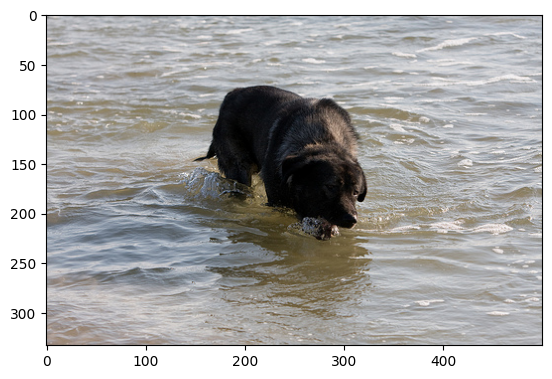

predicted
--------------------
 a black dog walking through water 

caption
--------------------
 a dark dog is in a body of water 



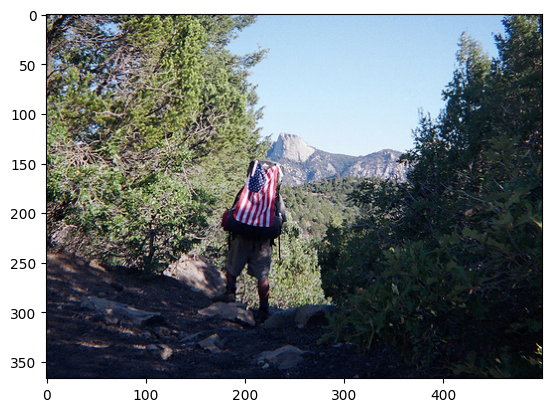

predicted
--------------------
 a hiker with an american flag on his backpack walks through the woods 

caption
--------------------
 a backpacker in the mountains wearing an american flag 



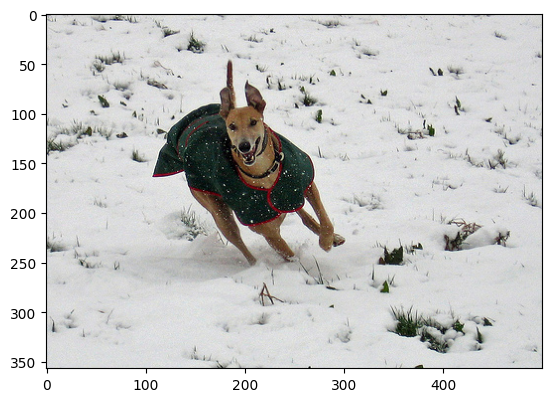

predicted
--------------------
 a dog wearing a cover walking down snow 

caption
--------------------
 dog wearing a coat running in a snowy field 



In [31]:
visualize_model_results(model, test_data)